In [ ]:
%pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
%pip install -U -q "google-genai==1.7.0"

In [2]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [5]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for model in client.models.list():
  if 'embedContent' in model.supported_actions:
    print(model.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [11]:
texts = [
    'Let me finish this and then we will continue with the remaining tasks.',
    'Let me finish this.',
    'we will continue with the remaining tasks.',
    'a quick brown fox jumps over lazy dog.',
    'remaining tasks',
    'finsih this',
    # Alternative pangram for comparison:
    'The five boxing wizards jump quickly.',
    # Unrelated text, also for comparison:
    'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus et hendrerit massa. Sed pulvinar, nisi a lobortis sagittis, neque risus gravida dolor, in porta dui odio vel purus.',
]

response = client.models.embed_content(
    model='models/text-embedding-004',
    contents=texts,
    config=types.EmbedContentConfig(task_type='semantic_similarity'))

#truncate to display longer embeddings in the visualization
def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

truncated_texts = [truncate(t) for t in texts]

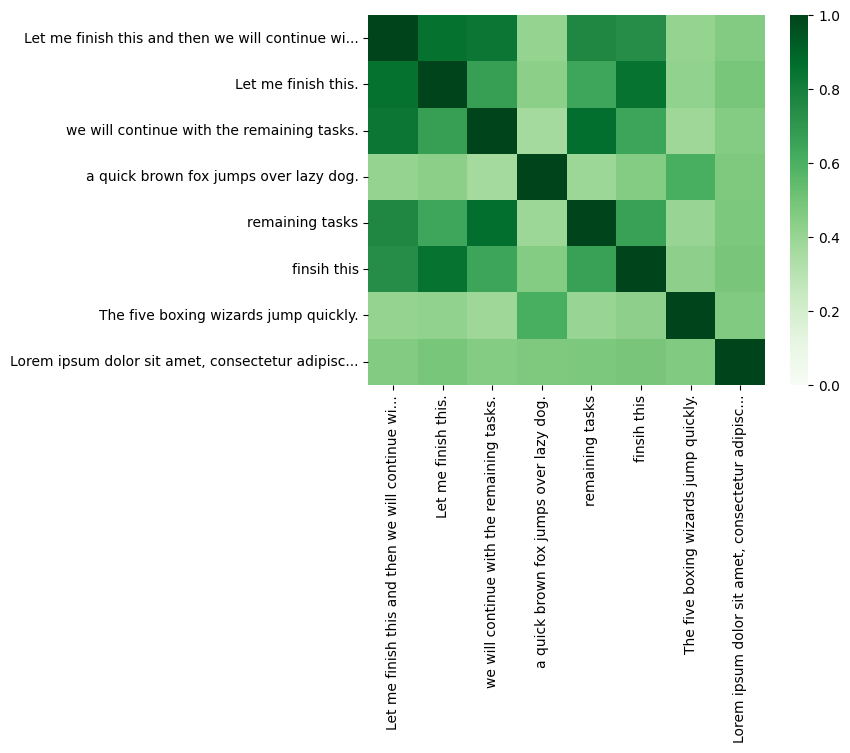

In [12]:
import pandas as pd
import seaborn as sns


# Set up the embeddings in a dataframe.
df = pd.DataFrame([e.values for e in response.embeddings], index=truncated_texts)
# Perform the similarity calculation
sim = df @ df.T
# Draw!
sns.heatmap(sim, vmin=0, vmax=1, cmap="Greens");


In [13]:
sim['Let me finish this.'].sort_values(ascending=False)

Let me finish this.                                   0.999999
Let me finish this and then we will continue wi...    0.851868
finsih this                                           0.850552
we will continue with the remaining tasks.            0.670081
remaining tasks                                       0.642843
Lorem ipsum dolor sit amet, consectetur adipisc...    0.492169
a quick brown fox jumps over lazy dog.                0.436708
The five boxing wizards jump quickly.                 0.419873
Name: Let me finish this., dtype: float64

In [18]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
print(newsgroups_train.target_names)
print(newsgroups_train.data[0])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have o

In [20]:
import email
import re
import pandas as pd

def preprocess_newsgroup_row(data):
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    text = text[:5000]
    return text

def preprocess_newsgroup_data(newsgroup_dataset):
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


In [44]:
def sample_data(df, num_samples, classes_to_keep):
    df = df[df["Class Name"].str.contains(classes_to_keep, na=False)]

    df = (
        df.groupby("Label", group_keys=False)  # Avoids duplicate index issues
        .apply(lambda x: x.drop(columns=["Label"]).sample(min(num_samples, len(x)), replace=False))
        .reset_index()
    )

    # Re-calibrate label encoding after filtering
    df["Class Name"] = df["Class Name"].astype("category")
    df["Encoded Label"] = df["Class Name"].cat.codes

    return df

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

print(df_train.value_counts("Class Name"))
print(df_test.value_counts("Class Name"))

Class Name
sci.crypt          55
sci.electronics    55
sci.med            55
sci.space          55
Name: count, dtype: int64
Class Name
sci.crypt          25
sci.electronics    25
sci.med            25
sci.space          25
Name: count, dtype: int64


<ipython-input-44-153140d7a476>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop(columns=["Label"]).sample(min(num_samples, len(x)), replace=False))
<ipython-input-44-153140d7a476>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop(columns=["Label"]).sample(min(num_samples, len(x)), replace=False))


In [45]:
from google.api_core import retry
import tqdm
from tqdm.rich import tqdm as tqdmr
import warnings

tqdmr.pandas()

warnings.filterwarnings("ignore", category=tqdm.TqdmExperimentalWarning)

# helper to retry when per-minute quota is reached for api calls
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

@retry.Retry(predicate=is_retriable, timeout=300.0)
def embed_fn(text: str) -> list[float]:
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=text,
        config=types.EmbedContentConfig(
            task_type="classification",
        ),
    )

    return response.embeddings[0].values
    
def create_embeddings(df):
    df["Embeddings"] = df["Text"].progress_apply(embed_fn)
    return df
    
df_train = create_embeddings(df_train)
df_test = create_embeddings(df_test)


Output()

Output()

In [47]:
df_train.head(10)

,index,Text,Class Name,Encoded Label,Embeddings
0,31,"Re: Once tapped, your code is no good any more...",sci.crypt,0,"[-0.0013634112, 0.01858307, -0.034085795, 0.03..."
1,32,"Re: Would ""clipper"" make a good cover for othe...",sci.crypt,0,"[0.0028607806, 0.024539866, -0.060172822, 0.02..."
2,4,Re: text of White House announcement and Q&As ...,sci.crypt,0,"[-0.01607567, 0.020984419, -0.03540242, 0.0125..."
3,51,"Re: Once tapped, your code is no good any more...",sci.crypt,0,"[-0.002856464, 0.013985532, -0.04379557, 0.029..."
4,24,Re: How does it really work? (was Re: text of ...,sci.crypt,0,"[0.018382102, 0.029029483, -0.0710524, 0.03198..."
5,39,Re: An Open Letter to Mr. Clinton\n\nIn articl...,sci.crypt,0,"[-0.0021818292, 0.025951998, -0.04781491, 0.02..."
6,43,Re: text of White House announcement and Q&As ...,sci.crypt,0,"[-0.008661169, 0.016787743, -0.05121004, 0.009..."
7,14,Re: List of large integer arithmetic packages\...,sci.crypt,0,"[0.019090815, 0.019883182, -0.050637122, 0.020..."
8,37,Re: freely distributable public key cryptograp...,sci.crypt,0,"[0.0074570705, 0.002348694, -0.057918686, 0.02..."
9,18,"Re: Once tapped, your code is no good any more...",sci.crypt,0,"[0.005239672, 0.018618511, -0.0505974, 0.02780..."


In [49]:
import keras
from keras import layers

def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
    return keras.Sequential(
        [
            layers.Input([input_size], name="embedding_inputs"),
            layers.Dense(input_size, activation="relu", name="hidden"), #ReLU activation for non-linearity
            layers.Dense(num_classes, activation="softmax", name="output_probs"),#Softmax converts raw scores into probabilities(ideal for multi-class classification)
        ]
    )
embedding_size = len(df_train["Embeddings"].iloc[0])

classifier = build_classification_model(
    embedding_size, len(df_train["Class Name"].unique())
)
classifier.summary()

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden (Dense)                       │ (None, 768)                 │         590,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_probs (Dense)                 │ (None, 4)                   │           3,076 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 593,668 (2.26 MB)

 Trainable params: 593,668 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
import numpy as np

NUM_EPOCHS = 20
BATCH_SIZE = 32

y_train = df_train["Encoded Label"]
x_train = np.stack(df_train["Embeddings"])
y_val = df_test["Encoded Label"]
x_val = np.stack(df_test["Embeddings"])

# Specify to stop early if accuracy stabilises.
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

# Train the model for the desired number of epochs.
history = classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9845 - loss: 0.2476 - val_accuracy: 0.8900 - val_loss: 0.4570
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9874 - loss: 0.2274 - val_accuracy: 0.8700 - val_loss: 0.4347
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9952 - loss: 0.1892 - val_accuracy: 0.8800 - val_loss: 0.4024
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9879 - loss: 0.1737 - val_accuracy: 0.8900 - val_loss: 0.3908
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9974 - loss: 0.1657 - val_accuracy: 0.8800 - val_loss: 0.3674
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9881 - loss: 0.1563 - val_accuracy: 0.8900 - val_loss: 0.3474
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9893 - loss: 0.1303 - val_accuracy: 0.8900 - val_loss: 0.3445
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9952 - loss: 0.1127 - val_accuracy: 0.9100 - val_loss: 0.3181


In [54]:
#evaluate model performance
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9140 - loss: 0.3142 


{'accuracy': 0.9100000262260437, 'loss': 0.31806010007858276}

In [56]:
#custom prediction
def make_prediction(text: str) -> list[float]:
    """Infer categories from the provided text."""
    embedded = embed_fn(new_text)

    # And recall that the input must be batched, so here they are wrapped as a list to provide a batch of 1.
    inp = np.array([embedded])

    # un-batched input.
    [result] = classifier.predict(inp)
    return result

#checking for bias :))
new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

result = make_prediction(new_text)

for idx, category in enumerate(df_test["Class Name"].cat.categories):
    print(f"{category}: {result[idx] * 100:0.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
sci.crypt: 0.10%
sci.electronics: 2.51%
sci.med: 0.25%
sci.space: 97.13%
